# GIN Index O(N^2) Lookup

The code below demonstrates `O(N^2)` behavior for GIN index lookups using the `&& ARRAY[...]` operator where `N` is the number of elements in the array.

From my (naive) understanding of how GIN indexes work, I'd assume `O(N)` performance instead.

In [1]:
# Install dependencies
!pip3 install psycopg2-binary
!pip3 install pandas
!pip3 install matplotlib
!pip3 install numpy

In [2]:
# Import modules and setup matplotlib inlining and pandas row display options
%matplotlib inline
import psycopg2
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 20)

In [3]:
# Connect to our database: you may change this DSN if you're not using the supplied docker-compose file.
# We also set autocommit to True so we can run VACUUUM (which is non-transactional) below.
pg_dsn = 'postgres://postgres@localhost:9999/postgres'
conn = psycopg2.connect(pg_dsn)
conn.autocommit = True
cur = conn.cursor()

In [4]:
# Create a table with lots of rows and array elements. You can see the data in the table below.
rows = 100000
keys_per_row = 3

cur.execute("""
DROP SCHEMA IF EXISTS gin CASCADE;
CREATE SCHEMA gin;
SET search_path = gin;

CREATE TABLE example AS
SELECT 
	a AS id,
	array_agg((a-1)*%s+b) AS keys
FROM
	generate_series(1, %s) a,
	generate_series(1, %s) b
GROUP BY 1;
CREATE INDEX ON example USING GIN (keys);
""", (keys_per_row, rows, keys_per_row))
cur.execute('VACUUM ANALYZE example')

pd.read_sql_query('SELECT * from example ORDER BY id ASC', con=conn)

,id,keys
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6]"
2,3,"[7, 8, 9]"
3,4,"[10, 11, 12]"
4,5,"[13, 14, 15]"
5,6,"[16, 17, 18]"
6,7,"[19, 20, 21]"
7,8,"[22, 23, 24]"
8,9,"[25, 26, 27]"
9,10,"[28, 29, 30]"


In [5]:
# Force the query planner to use our gin index, even if it would prefer a seqscan and show the query plan for the query
# we're testing below.
cur.execute("SET enable_seqscan=false")
cur.execute("EXPLAIN ANALYZE SELECT * FROM example WHERE keys && ARRAY[1,2,3]")
print('\n'.join([x[0] for x in cur.fetchall()]))

Bitmap Heap Scan on example  (cost=51.57..924.35 rows=1493 width=37) (actual time=0.058..0.063 rows=1 loops=1)
  Recheck Cond: (keys && '{1,2,3}'::integer[])
  Heap Blocks: exact=1
  ->  Bitmap Index Scan on example_keys_idx  (cost=0.00..51.19 rows=1493 width=0) (actual time=0.025..0.025 rows=1 loops=1)
        Index Cond: (keys && '{1,2,3}'::integer[])
Planning time: 0.216 ms
Execution time: 0.198 ms


In [6]:
# Run our benchmark, basically just running the query from above with an increasing amount of elements in the
# array we're performing an overlap operation with.
step = 100
steps = 100
results = []
for p in range(steps):
    keys = [k+1 for k in range(step * (p+1))]
    cur.execute("EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s", (keys,))
    plan = '\n'.join([x[0] for x in cur.fetchall()])
    
    # make sure all our queries used our index
    if plan.find('Index Scan') < 0:
        raise Exception("unexpected query plan")

    time = float(re.search('Execution time: ([0-9.]+)', plan)[1])
    result = (len(keys), time)
    results.append(result)

In [7]:
df = pd.DataFrame(results, columns=["keys", "time"])
df

,keys,time
0,100,1.117
1,200,1.326
2,300,2.438
3,400,3.676
4,500,4.828
5,600,9.607
6,700,10.501
7,800,10.742
8,900,17.047
9,1000,20.713


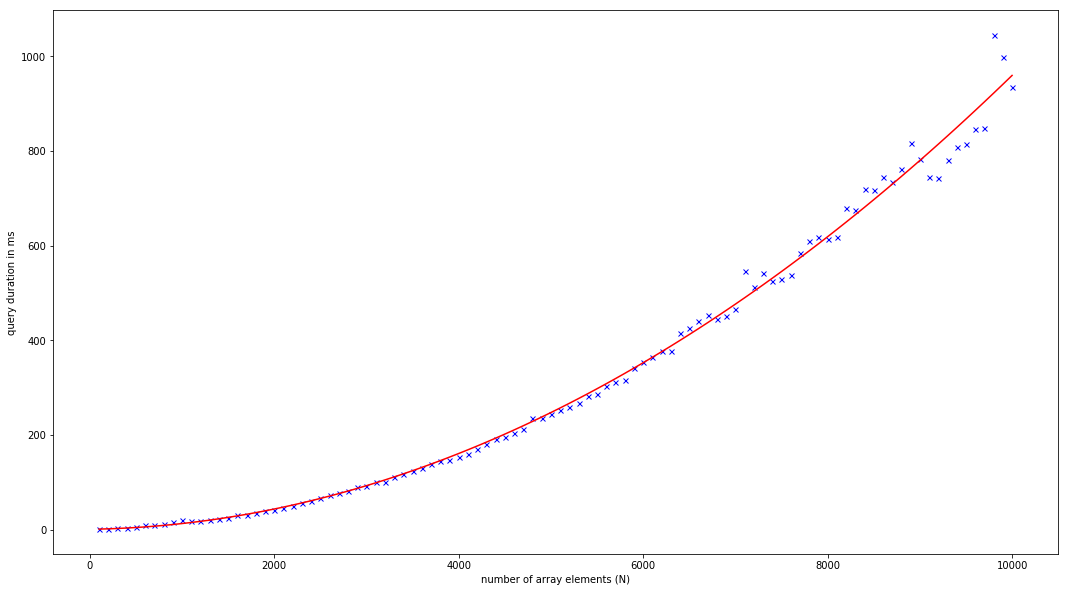

In [8]:
# plot our data and also fit a 2nd degree polynomial to show the O(N^2) behavior
coefs = np.polyfit(df['keys'], df['time'], 2)
p = np.poly1d(coefs)
fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.plot(df['keys'], df['time'], "bx", markersize=5)
ax.plot(df['keys'], p(df['keys']), "r-") #p(X) evaluates the polynomial at X
ax.set_xlabel('number of array elements (N)')
ax.set_ylabel('query duration in ms')
ax